### tsdGAN: A generative adversarial network approach for removing electrocardiographic interference from electromyographic signals 
Lucas Haberkamp<sup>1,2</sup>, Charles A. Weisenbach<sup>1</sup>, Peter Le<sup>3</sup>  
<sup>1</sup>Naval Medical Research Unit Dayton, Wright-Patterson Air Force Base, OH, USA   
<sup>2</sup>Leidos, Reston, VA, USA   
<sup>3</sup>Air Force Research Laboratory, 711th Human Performance Wing, Wright-Patterson Air Force Base, OH, USA 

#### This notebook evaluates the performance of the denoising approaches

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, spatial
import pickle
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

Load in synthetic validation dataset

In [2]:
with open('../../Data/Preprocessed Data/Synthetic/Validation/x_val.pkl', 'rb') as f:
  x_val = pickle.load(f)

with open('../../Data/Preprocessed Data/Synthetic/Validation/y_val.pkl', 'rb') as f:
  y_val = pickle.load(f)

In [3]:
filters = {}


with open('../../Data/Synthetic Predictions/tsdGAN.pkl', 'rb') as f:
  filters['tsdGAN'] = pickle.load(f)

with open('../../Data/Synthetic Predictions/TemplateSubtraction.pkl', 'rb') as f:
  filters['TemplateSubtraction'] = pickle.load(f)

with open('../../Data/Synthetic Predictions/HPF.pkl', 'rb') as f:
  filters['HPF'] = pickle.load(f)

with open('../../Data/Synthetic Predictions/DynamicFiltration.pkl', 'rb') as f:
  filters['DynamicFiltration'] = pickle.load(f)


In [4]:
def SNR(y_true, y_pred):
    diff = y_true - y_pred
    
    num = np.var(y_true)
    den = np.var(diff)

    # calculate the SNR in dB
    snr = 10*np.log10(num/den)
    return snr

def freq_transform(data, Fs):
    # Window length of 1 second 
    nperseg = Fs*1
    # 75% overlap
    noverlap = np.ceil(nperseg * 0.75) 
    # Hann window
    window = 'hann'  
    # Zero-padding to the next power of two
    nfft = 2**np.ceil(np.log2(nperseg))

    freq, pxx = signal.welch(data, fs=Fs, window=window, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
    return pxx

In [5]:
for _, f_type in enumerate(filters.keys()):
    print(f_type)

tsdGAN
TemplateSubtraction
HPF
DynamicFiltration


In [11]:
data_dict = {'Trial': [],
'SNR_Level': [],
'Filter': [], 
'Filtered_SNR': [],
'JSD': []
}

Fs = 2148 

for _, key in enumerate(x_val.keys()):

        for i in range(len(y_val[key])):

            y_true = y_val[key][i].squeeze()
            y_pred = filters['HPF'][key][i].squeeze()

            y_true_pxx = freq_transform(data=y_true, Fs=Fs)

            for _, f_type in enumerate(filters.keys()):
                data_dict['Filter'].append(f_type)

                y_pred = filters[f_type][key][i].squeeze()

                # Calculate y_pred MF
                y_pred_pxx = freq_transform(data=y_pred, Fs=Fs)

                data_dict['Filtered_SNR'].append(SNR(y_true, y_pred))

                JSD = spatial.distance.jensenshannon(y_true_pxx, y_pred_pxx, base=2)
                data_dict['JSD'].append(JSD*10)

                data_dict['Trial'].append(i)
                data_dict['SNR_Level'].append(key)

for key in data_dict:
    data_dict[key] = np.array(data_dict[key])

df = pd.DataFrame(data_dict)
df.head()

,Trial,SNR_Level,Filter,Filtered_SNR,JSD
0,0,1,tsdGAN,15.677102,0.397171
1,0,1,TemplateSubtraction,10.546585,0.693681
2,0,1,HPF,7.394663,1.252372
3,0,1,DynamicFiltration,5.088802,1.383152
4,1,1,tsdGAN,15.097773,0.409762


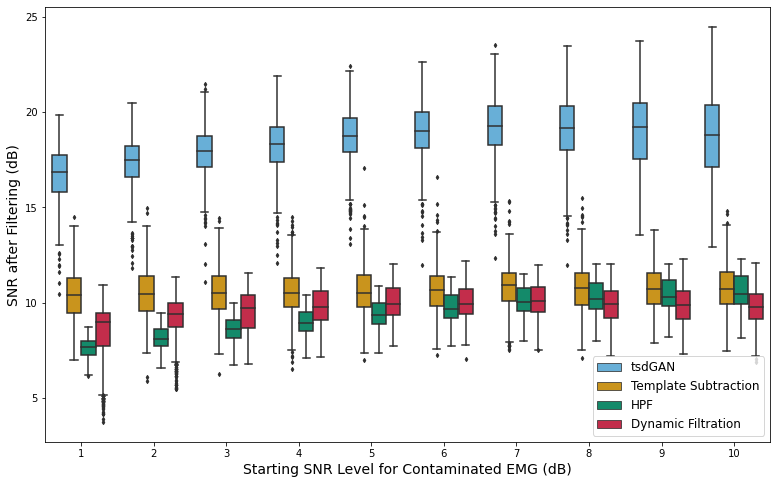

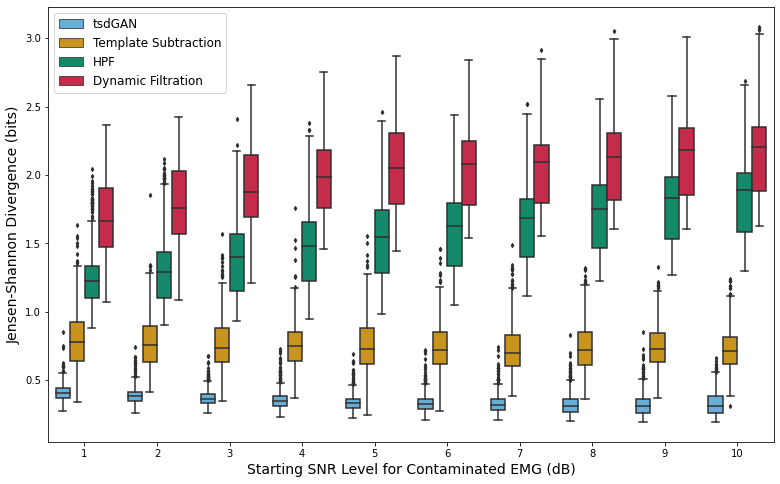

In [12]:
def plot_box(dataframe, ycolumn, ylabel, title):
    palette = ['#56B4E9', '#E69F00', '#009E73', '#DC143C']

    plt.figure(figsize=(13, 8), facecolor='white')
    f = sns.boxplot(x='SNR_Level', y=ycolumn, hue='Filter', 
                palette=palette, data=dataframe, fliersize=3)

    plt.legend(fontsize=12)
    
    f.legend_.texts[0].set_text("tsdGAN")
    f.legend_.texts[1].set_text("Template Subtraction")
    f.legend_.texts[2].set_text("HPF")
    f.legend_.texts[3].set_text("Dynamic Filtration")

    # plt.title(title, fontsize=14)
    plt.xlabel('Starting SNR Level for Contaminated EMG (dB)', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.savefig(f"../../Plots/Boxplots/{title}.png", dpi=500)
    plt.show()


plot_box(df, ycolumn='Filtered_SNR', ylabel='SNR after Filtering (dB)', title='Effect of Filtering on SNR')

plot_box(df, ycolumn='JSD', ylabel='Jensen-Shannon Divergence (bits)', title='Effect of Filtering on Jensen-Shannon Divergence')


In [13]:
def plot_box(dataframe, ycolumn, ylabel, title):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='SNR_Level', y=ycolumn, hue='Filter', data=dataframe, fliersize=3)
    plt.title(title)
    plt.xlabel('SNR Level (dB)')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

def plot_model_diagnostics(model):
    # Calculate residuals
    residuals = model.resid_response

    # Set up the matplotlib figure for subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    
    # Histogram of Residuals
    axs[0].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='g')
    axs[0].axvline(x=0, color='grey', linestyle='dashed')
    axs[0].set_xlabel('Residuals')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('Histogram of Residuals')

    # S-L Plot
    # Residuals vs Fitted
    sns.scatterplot(x=model.fittedvalues, y=np.abs(residuals), ax=axs[1])

    # Calculate a line of best fit
    fit = np.polyfit(model.fittedvalues, np.abs(residuals), 1) # 1 means linear (first-degree polynomial)
    fit_fn = np.poly1d(fit) 

    # Plot the line of best fit
    axs[1].plot(model.fittedvalues, fit_fn(model.fittedvalues), color='red') # change color if needed
    axs[1].set_xlabel('Fitted values')
    axs[1].set_ylabel('Absolute Value of Residuals')
    axs[1].set_title('S-L Plot')

    # Residuals vs Fitted
    sns.scatterplot(x=model.fittedvalues, y=residuals, ax=axs[2])
    axs[2].axhline(0, color='grey', linestyle='dashed')
    axs[2].set_xlabel('Fitted values')
    axs[2].set_ylabel('Residuals')
    axs[2].set_title('Residuals vs Fitted')

    plt.show()


                 Generalized Linear Model Regression Results                  
Dep. Variable:           Filtered_SNR   No. Observations:                20000
Model:                            GLM   Df Residuals:                    19992
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                          1.6856
Method:                          IRLS   Log-Likelihood:                -33596.
Date:                Thu, 15 Feb 2024   Deviance:                       33699.
Time:                        09:43:35   Pearson chi2:                 3.37e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9998
Covariance Type:            nonrobust                                         
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

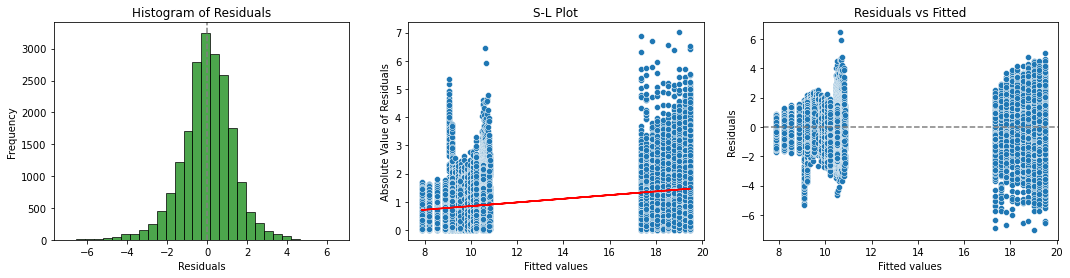

In [14]:
# Define the family and the link function
family_link = sm.families.Gaussian(link=sm.families.links.identity())

# Fit the generalized linear model with the specified link function
model_eval = smf.glm(formula="Filtered_SNR ~ C(Filter, Treatment(reference='tsdGAN')) + C(Filter, Treatment(reference='tsdGAN')):SNR_Level",
                     data=df, 
                     family=family_link).fit()

print(model_eval.summary())

plot_model_diagnostics(model_eval)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    JSD   No. Observations:                20000
Model:                            GLM   Df Residuals:                    19992
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                        0.055173
Method:                          IRLS   Log-Likelihood:                 597.97
Date:                Thu, 15 Feb 2024   Deviance:                       1103.0
Time:                        09:43:35   Pearson chi2:                 1.10e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9996
Covariance Type:            nonrobust                                         
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

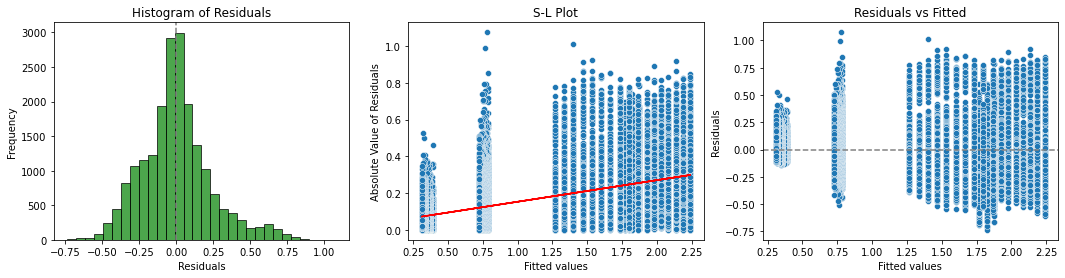

In [15]:
# Define the family and the link function
family_link = sm.families.Gaussian(link=sm.families.links.identity())

# Fit the generalized linear model with the specified link function
model_eval = smf.glm(formula="JSD ~ C(Filter, Treatment(reference='tsdGAN')) + C(Filter, Treatment(reference='tsdGAN')):SNR_Level",
                     data=df, 
                     family=family_link).fit()

print(model_eval.summary())

plot_model_diagnostics(model_eval)